# Comparing the forecasting performance

The project of emotion forecasting has two main directions. Based on our hypotheses, we divide our comparisons in following groups:
    1. Dynamic or sequential deep learning will perform better than static deep learning for Emotion Forecasting. In other words,
    LSTM and BLSTM will work better than FCDNN.
    2. If we consider sequential deep learning, the added-history context will improve performance from the non-history version.

**Thus, we will start our experiments proving the first hypothesis, i.e., LSTM or BLSTM performs better than FC-DNN. **

In [4]:
from Codes.Combine_audiovisual_data import combining_AV
from Codes.window_based_reformation import window_based_reformation
from Codes.Utt_Fore_Data_Prep import Prepare_UF_Cur_Data, Prepare_UF_history_Data

"""
First, we create the dataset for static and dynamic learning
"""
#Combine the audiovisual data first
Combining_data = combining_AV('Files/audio_features', 'Files/video_features')
Combining_data.produce_speakerwise_AV_data()
#Perform the window -based feature calculation
Windowing = window_based_reformation('Files/sameframe')
Windowing.process_data(window_type='static') #For static feature generation
Windowing.process_data(window_type='dynamic') #For dynamic feature generation

for steps in [1, 2, 3]:
    UF_cur = Prepare_UF_Cur_Data()
    UF_cur.creating_dataset(step=steps, feature_type='dyanmic', normalization=True)
    UF_cur.creating_dataset(step=steps, feature_type='static', normalization=True)

Combining the feature set...
Creating window based features...
Creating dataset for utterance forecasting...


Next, we run FC-DNN, LSTM, and BLSTM. 

As our performance will be evaluated using Unweighted Average Recall (UWR) over all the 10 speakers, we'll first create a function to calculate the UWR.

In [7]:
from sklearn.metrics import recall_score

def calc_UWR(Truth, Pred):
    """
    The function takes the ground truth and prediction for all 10 groups or speakers and returns a
    mean UWR
    """
    All_recall = 0
    for speaker in range(1, 11):
        All_recall = All_recall + recall_score(Truth[speaker], Pred[speaker], average='macro') 
        
    return All_recall*100/10

The next step is, we'd like to compare the performance of static vs dynamic modeling. 

In [76]:
from Codes.run_algorithms import run_deep_learning
import pandas as pd

UWR_static_vs_dynamic = pd.DataFrame(columns = ['steps', 'UWR_FC_DNN', 'UWR_LSTM', 'UWR_BLSTM'])
for steps in [1, 2, 3]:
    UWR = {}
    UWR['steps'] = steps
    forecast = run_deep_learning()
    #sequential learning portion:
    features, label, speaker_group = forecast.prepare_data(directory='Files/UF_Cur_data/step_{}/dynamic', 
                                                           feature_type='dynamic') #Change the file location accordingly
    Ground_Truth, Prediction, Probability = forecast.LSTM(features, label, speaker_group, 
                                                          model_type='unidirectional') #if model_type set to bidirectional, it will be BLSTM
    
    UWR['UWR_LSTM'] = calc_UWR(Ground_Truth, Prediction)
    Ground_Truth, Prediction, Probability = forecast.LSTM(features, label, speaker_group, 
                                                          model_type='bidirectional')
    UWR['UWR_BLSTM'] = calc_UWR(Ground_Truth, Prediction)
    
     #Static learning portion:
    features, label, speaker_group = forecast.prepare_data(directory='Files/UF_Cur_data/step_{}/static', 
                                                           feature_type='static') #Change the file location accordingly
    Ground_Truth, Prediction, Probability = forecast.FC_DNN(features, label, speaker_group) 
    UWR['UWR_FC_DNN'] = calc_UWR(Ground_Truth, Prediction)
    UWR_static_vs_dynamic = UWR_static_vs_dynamic.append(UWR, ignore_index=True)
    
UWR_static_vs_dynamic.head()

,UWR_FC_DNN,UWR_LSTM,UWR_BLSTM,steps
0,57.96,58.93,58.95,1
1,54.45,55.73,56.36,2
2,51.40,52.99,52.25,3


Let's visualize this with a bar plot:

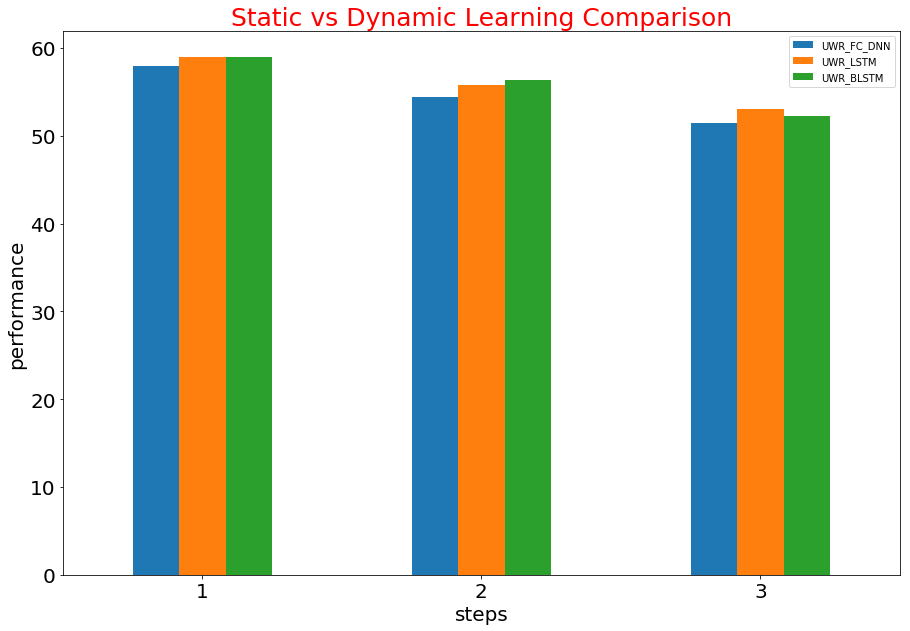

In [79]:
ax = UWR_static_vs_dynamic[["UWR_FC_DNN", "UWR_LSTM", "UWR_BLSTM"]].plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("steps", fontsize=20)
ax.set_ylabel("performance", fontsize=20)
ax.set_xticklabels(['1', '2', '3'], rotation=0)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_title('Static vs Dynamic Learning Comparison', fontsize=25, color='r')
plt.show()

The bar plot clearly suggests that in evert case, the dynamic learning performance (LSTM or BLSTM) is better than the static learning performance (FC-DNN)

**Next, we will work on our second hypotheis. That means, adding history context while doing sequential learning, improves the forecasting performance **

First, let's create the dataset for history-added forecasting.

In [49]:
for steps in [1, 2, 3]:
    UF_his = Prepare_UF_history_Data()
    UF_his.creating_dataset(step=steps, feature_type='dyanmic', normalization=True)

Creating dataset for utterance forecasting...


In [ ]:
UWR_cur_vs_his_LSTM = pd.DataFrame(columns = ['No_history', 'Added_history'])
UWR_cur_vs_his_BLSTM = pd.DataFrame(columns = ['No_history', 'Added_history'])
UWR_cur_vs_his_LSTM['No_history'] = UWR_static_vs_dynamic['UWR_LSTM'].tolist()
UWR_cur_vs_his_BLSTM['No_history'] = UWR_static_vs_dynamic['UWR_BLSTM'].tolist()

for steps in [1, 2, 3]:
    forecast = run_deep_learning()
    #sequential learning portion:
    features, label, speaker_group = forecast.prepare_data(directory='Files/UF_His_data/step_{}/dynamic', 
                                                           feature_type='dynamic') #Change the file location accordingly
    Ground_Truth, Prediction, Probability = forecast.LSTM(features, label, speaker_group, 
                                                          model_type='unidirectional') #if model_type set to bidirectional, it will be BLSTM
    
    UWR_cur_vs_his_LSTM[ 'Added_history'][steps-1] = calc_UWR(Ground_Truth, Prediction)
    Ground_Truth, Prediction, Probability = forecast.LSTM(features, label, speaker_group, 
                                                          model_type='bidirectional')
    UWR_cur_vs_his_BLSTM[ 'Added_history'][steps-1] = calc_UWR(Ground_Truth, Prediction)

In [81]:
UWR_cur_vs_his_BLSTM.head()

,No_history,Added_history
0,58.95,61.33
1,56.36,58.37
2,52.25,54.64


In [82]:
UWR_cur_vs_his_LSTM.head()

,No_history,Added_history
0,58.93,60.68
1,55.73,56.51
2,52.99,53.33


Let's plot the performance.

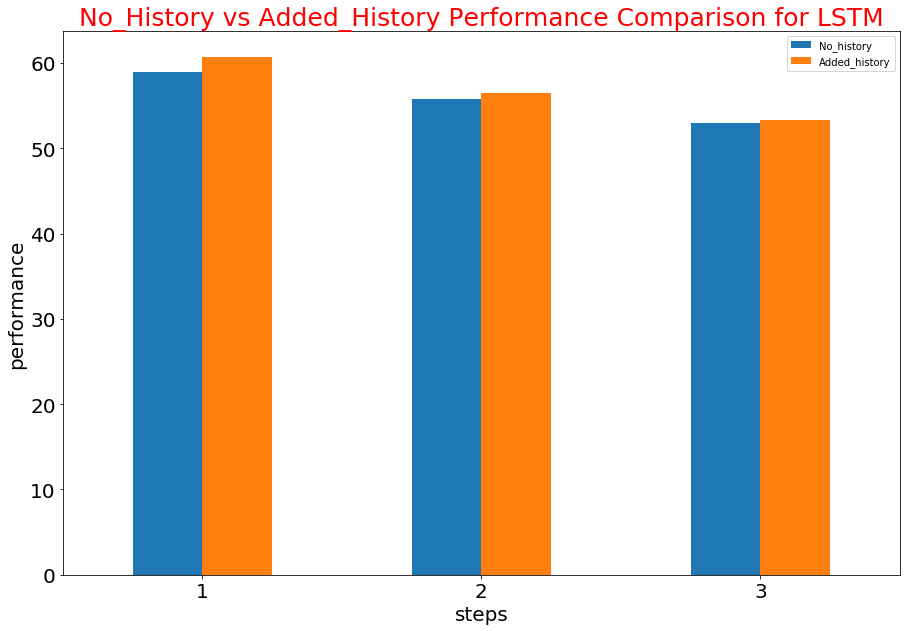

In [86]:
ax = UWR_cur_vs_his_LSTM[["No_history", "Added_history"]].plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("steps", fontsize=20)
ax.set_ylabel("performance", fontsize=20)
ax.set_xticklabels(['1', '2', '3'], rotation=0)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_title('No_History vs Added_History Performance Comparison for LSTM', fontsize=25, color='r')
plt.show()

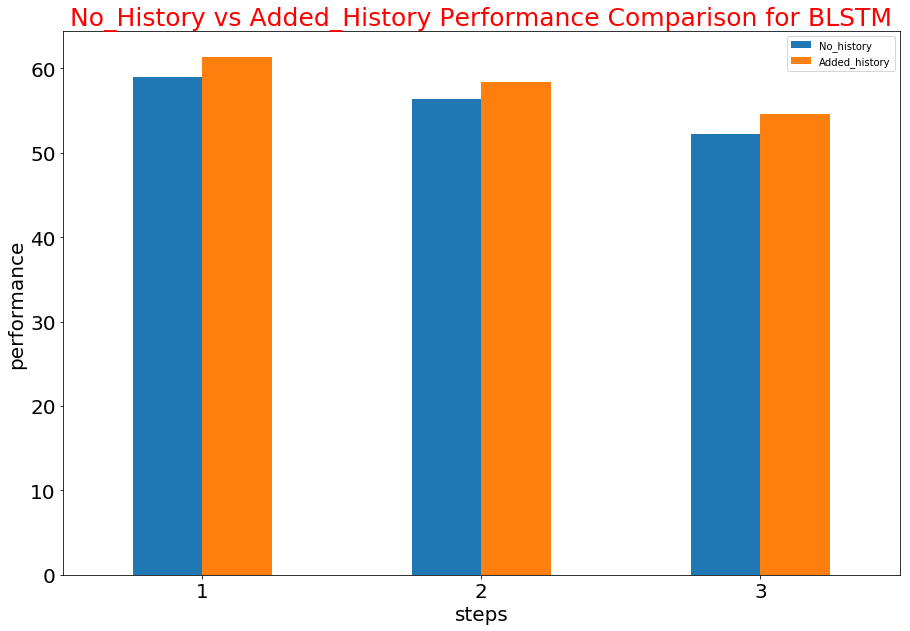

In [87]:
ax = UWR_cur_vs_his_BLSTM[["No_history", "Added_history"]].plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("steps", fontsize=20)
ax.set_ylabel("performance", fontsize=20)
ax.set_xticklabels(['1', '2', '3'], rotation=0)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_title('No_History vs Added_History Performance Comparison for BLSTM', fontsize=25, color='r')
plt.show()

**Therefore, from the above plot we may infer that adding the history context along with the current data improves the forecasting performance !**